## Perform analysis and visualization

In [59]:
import os
import re
import sys
import glob
import tzlocal
from fuzzywuzzy import fuzz
import numpy as np

import pandas as pd
from scipy import io
from dbfread import DBF
from collections import Counter
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from rpy2.robjects import packages
from rpy2.robjects import pandas2ri
from simpledbf import Dbf5
from dbfread import DBF

def read_dbf(file):
    tmp = DBF(file)
    tmp = pd.DataFrame(iter(tmp))
    return tmp

def read_sav(file):
    foreign = packages.importr('foreign')
    pandas2ri.activate()
    df = foreign.read_spss(file, reencode=False)
    return pd.DataFrame(dict(zip(df.names, map(list,list(df)))))

def read_dta(file):
    itr = pd.read_stata(file, iterator=True)
    variables = list(itr.variable_labels().values())
    data = pd.read_stata(os.path.join(file))
    original_variables = data.columns
    data.columns = variables
    return data, original_variables
def match_districts(ref_df, ref_match, input_df, idvar):
    out = pd.DataFrame()
    print(input_df.columns)
    for key, code in enumerate(input_df[idvar]):
        code_match = {}
        code_match['FuzzRatio'] = [fuzz.ratio(ref_code, code)  for ref_code in ref_df[ref_match]]
        code_match['Geo'] = code
        code_match['DivisionCode'] = [value[0] for value in ref_df.values]
        code_match['DivisionName'] = [value[1]  for value in ref_df.values]
        code_match['DistrictCode'] = [value[2]  for value in ref_df.values]
        code_match['DistrictName'] = [value[3]  for value in ref_df.values]
        code_match = pd.DataFrame.from_dict(code_match)
        out = out.append(code_match.sort_values('FuzzRatio', ascending=False).iloc[0,:])
    for var in list(out.columns):
        if out[var].dtype.kind == 'f':
            out[var] = out[var].astype(int)
            out[var] = out[var].astype(str)
            code_length = max([len(char) for char in out[var]])
            out[var] = out[var].str.pad(width=code_length, side='left', fillchar='0') 
    return out

In [60]:
NCD = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/ncd/prevalence_all.csv'
CBR = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/ncd/crude_birth_rate.csv'

In [61]:
ncd = pd.read_csv(NCD)
cbr = pd.read_csv(CBR)

In [62]:
geos = pd.read_excel('/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/geo_files/geos_svrs.xlsx')
geos = geos[['dv','Div_Name','zl','Zila_Name','Zila_Name1', 'Zila_Name2']]
print(geos.shape)
geos = geos.drop_duplicates()
geos['zl'] = geos['zl'].astype(str).str.pad(width=2, side='left', fillchar='0')
geos['ZILA'] = geos['dv'].astype(str).str.cat(geos['zl'])
print(geos.shape)
geos.head()

(2012, 6)
(65, 7)


,dv,Div_Name,zl,Zila_Name,Zila_Name1,Zila_Name2,ZILA
0,10,Barisal,04,Barguna,Barguna,Barguna,1004
17,10,Barisal,06,Barisal,Barisal,Barishal,1006
111,10,Barisal,09,Bhola,Bhola,Bhola,1009
143,10,Barisal,42,Jhalokati,Jhalokati,Jhalokati,1042
157,10,Barisal,78,Patuakhali,Patuakhali,Patuakhali,1078


## STEP BY STEP APPROACH:
- DONE: Merge CBR to Geos by FIPS CODE
- DONE: Match NCD by Names and merge with NCD
- Merge NCD and CBR
- Select all years and indicators
- Calculate percent of change (2012-2017)
- Make estimates for the following three years
- 


In [63]:
df = match_districts(ref_df=geos, ref_match='Zila_Name2', input_df=ncd, idvar='DIVN_ZILA')     
print(ncd.shape)
ncd = ncd.merge(df, how='left',left_on='DIVN_ZILA', right_on='Geo')
ncd['ZILA'] = ncd['DivisionCode'].str.cat(ncd['DistrictCode'])
print(ncd.shape)
ncd = ncd.drop_duplicates()
print(ncd.shape)
ncd.head()

Index(['DIVN_ZILA', 'Hyperglycaemia count_d2012', 'Total count_d2012',
       'Hyperglycaemia prevalence_d2012', 'Hyperglycaemia count_d2014',
       'Total count_d2014', 'Hyperglycaemia prevalence_d2014',
       'Hyperglycaemia count_d2015', 'Total count_d2015',
       'Hyperglycaemia prevalence_d2015', 'Hyperglycaemia count_d2017',
       'Total count_d2017', 'Hyperglycaemia prevalence_d2017',
       'Hypertension count_h2012', 'Total count_h2012',
       'Hypertension prevalence_h2012', 'Hypertension count_h2014',
       'Total count_h2014', 'Hypertension prevalence_h2014',
       'Hypertension count_h2015', 'Total count_h2015',
       'Hypertension prevalence_h2015', 'Hypertension count_h2017',
       'Total count_h2017', 'Hypertension prevalence_h2017'],
      dtype='object')
(64, 25)
(64, 32)
(64, 32)


,DIVN_ZILA,Hyperglycaemia count_d2012,Total count_d2012,Hyperglycaemia prevalence_d2012,Hyperglycaemia count_d2014,Total count_d2014,Hyperglycaemia prevalence_d2014,Hyperglycaemia count_d2015,Total count_d2015,Hyperglycaemia prevalence_d2015,...,Hypertension count_h2017,Total count_h2017,Hypertension prevalence_h2017,DistrictCode,DistrictName,DivisionCode,DivisionName,FuzzRatio,Geo,ZILA
0,Bagerhat,1010,13369,7.55,450,5440,8.27,834,9270,9.00,...,2569,12012,21.39,01,Bagerhat,40,Khulna,100,Bagerhat,4001
1,Bandarban,199,11210,1.78,41,1948,2.10,91,3628,2.51,...,492,3295,14.93,03,Bandarban,20,Chittagong,100,Bandarban,2003
2,Barguna,764,13868,5.51,337,4528,7.44,583,7773,7.50,...,1961,9631,20.36,04,Barguna,10,Barisal,100,Barguna,1004
3,Barisal,1468,19779,7.42,2035,28069,7.25,2636,45334,5.81,...,3993,21077,18.94,06,Barisal,10,Barisal,093,Barisal,1006
4,Bhola,636,16751,3.80,443,8685,5.10,1119,15993,7.00,...,2530,15341,16.49,09,Bhola,10,Barisal,100,Bhola,1009


In [64]:
print(cbr.shape)
cbr['ZILA'] = cbr['ZILA'].astype(str)
cbr = cbr.merge(geos, how='left', on='ZILA')
cbr = cbr.drop_duplicates()
print(cbr.shape)

(64, 13)
(65, 19)


In [65]:
cbr.head()

,ZILA,SampleSize 2014,LiveBirths 2014,CBR 2014,SampleSize 2015,LiveBirths 2015,CBR 2015,SampleSize 2012,LiveBirths 2012,CBR 2012,SampleSize 2017,LiveBirths 2017,CBR 2017,dv,Div_Name,zl,Zila_Name,Zila_Name1,Zila_Name2
0,1004,4977,94,18.886880,7773,127,16.338608,13871,285,20.546464,10230,171,16.715543,10,Barisal,04,Barguna,Barguna,Barguna
1,1006,31252,530,16.958915,45404,747,16.452295,19779,383,19.363972,55321,1080,19.522424,10,Barisal,06,Barisal,Barisal,Barishal
2,1009,9684,211,21.788517,15999,362,22.626414,16772,305,18.185070,22253,287,12.897137,10,Barisal,09,Bhola,Bhola,Bhola
3,1042,5375,88,16.372093,6840,92,13.450292,12639,231,18.276762,8625,146,16.927536,10,Barisal,42,Jhalokati,Jhalokati,Jhalokati
4,1078,10572,168,15.891033,13782,261,18.937745,16259,315,19.373885,19052,356,18.685702,10,Barisal,78,Patuakhali,Patuakhali,Patuakhali


In [66]:
data = ncd.merge(right=cbr, how='left', on='ZILA')
print(data.shape)
data = data.drop_duplicates()
print(data.shape)
data.head()

(67, 50)
(67, 50)


,DIVN_ZILA,Hyperglycaemia count_d2012,Total count_d2012,Hyperglycaemia prevalence_d2012,Hyperglycaemia count_d2014,Total count_d2014,Hyperglycaemia prevalence_d2014,Hyperglycaemia count_d2015,Total count_d2015,Hyperglycaemia prevalence_d2015,...,CBR 2012,SampleSize 2017,LiveBirths 2017,CBR 2017,dv,Div_Name,zl,Zila_Name,Zila_Name1,Zila_Name2
0,Bagerhat,1010,13369,7.55,450,5440,8.27,834,9270,9.00,...,10.845176,12526,229,18.281973,40,Khulna,01,Bagerhat,Bagerhat,Bagerhat
1,Bandarban,199,11210,1.78,41,1948,2.10,91,3628,2.51,...,19.263355,4646,91,19.586741,20,Chittagong,03,Bandarban,Bandarban,Bandarban
2,Barguna,764,13868,5.51,337,4528,7.44,583,7773,7.50,...,20.546464,10230,171,16.715543,10,Barisal,04,Barguna,Barguna,Barguna
3,Barisal,1468,19779,7.42,2035,28069,7.25,2636,45334,5.81,...,19.363972,55321,1080,19.522424,10,Barisal,06,Barisal,Barisal,Barishal
4,Bhola,636,16751,3.80,443,8685,5.10,1119,15993,7.00,...,18.185070,22253,287,12.897137,10,Barisal,09,Bhola,Bhola,Bhola


In [67]:
data['Percent of change: CBR'] = (data['CBR 2017'] - data['CBR 2012']) / data['CBR 2012'] *100
data['Percent of change: Hypertension'] = (data['CBR 2017'] - data['CBR 2012']) / data['CBR 2012'] *100
data['Percent of change: Hyperglycaemia'] = (data['Hypertension prevalence_h2017'] - data['Hypertension prevalence_h2012']) / data['Hypertension prevalence_h2012'] *100

In [68]:
data.to_csv('/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/ncd/disease_burden.csv',index=False, index_label=False)

# Visual: Bangladesh levels

In [69]:
data.columns

Index(['DIVN_ZILA', 'Hyperglycaemia count_d2012', 'Total count_d2012',
       'Hyperglycaemia prevalence_d2012', 'Hyperglycaemia count_d2014',
       'Total count_d2014', 'Hyperglycaemia prevalence_d2014',
       'Hyperglycaemia count_d2015', 'Total count_d2015',
       'Hyperglycaemia prevalence_d2015', 'Hyperglycaemia count_d2017',
       'Total count_d2017', 'Hyperglycaemia prevalence_d2017',
       'Hypertension count_h2012', 'Total count_h2012',
       'Hypertension prevalence_h2012', 'Hypertension count_h2014',
       'Total count_h2014', 'Hypertension prevalence_h2014',
       'Hypertension count_h2015', 'Total count_h2015',
       'Hypertension prevalence_h2015', 'Hypertension count_h2017',
       'Total count_h2017', 'Hypertension prevalence_h2017', 'DistrictCode',
       'DistrictName', 'DivisionCode', 'DivisionName', 'FuzzRatio', 'Geo',
       'ZILA', 'SampleSize 2014', 'LiveBirths 2014', 'CBR 2014',
       'SampleSize 2015', 'LiveBirths 2015', 'CBR 2015', 'SampleSize 2012',

In [70]:
bangladesh = data[['Hyperglycaemia count_d2012', 'Total count_d2012', 'Hyperglycaemia count_d2014', 
                   'Total count_d2014', 'Hyperglycaemia count_d2015', 'Total count_d2015',
                   'Hyperglycaemia count_d2017','Total count_d2017', 'Hypertension count_h2012', 
                   'Total count_h2012', 'Hypertension count_h2014', 'Total count_h2014',
                   'Hypertension count_h2015', 'Total count_h2015','Hypertension count_h2017',
                   'Total count_h2017', 'SampleSize 2014', 'LiveBirths 2014', 'SampleSize 2015',
                   'LiveBirths 2015', 'SampleSize 2012','LiveBirths 2012', 'SampleSize 2017', 
                   'LiveBirths 2017',]]

In [71]:
bangladesh = bangladesh.sum(axis=0)

# Plotting Maps

In [72]:
import os
import re
import glob
import conda
import hdbscan
import operator
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import matplotlib.cm


In [73]:
SHAPEFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/geo_files/gadm36_BGD_shp/gadm36_BGD_2'
GEOFILE = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/geo_files/geos_svrs.xlsx'
OUTPUT = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/ncd/plots/'
GEO_LEVEL = 'districts'
PROJECT = "Precent of change in prevalence of hypertension"

In [74]:
data.columns


Index(['DIVN_ZILA', 'Hyperglycaemia count_d2012', 'Total count_d2012',
       'Hyperglycaemia prevalence_d2012', 'Hyperglycaemia count_d2014',
       'Total count_d2014', 'Hyperglycaemia prevalence_d2014',
       'Hyperglycaemia count_d2015', 'Total count_d2015',
       'Hyperglycaemia prevalence_d2015', 'Hyperglycaemia count_d2017',
       'Total count_d2017', 'Hyperglycaemia prevalence_d2017',
       'Hypertension count_h2012', 'Total count_h2012',
       'Hypertension prevalence_h2012', 'Hypertension count_h2014',
       'Total count_h2014', 'Hypertension prevalence_h2014',
       'Hypertension count_h2015', 'Total count_h2015',
       'Hypertension prevalence_h2015', 'Hypertension count_h2017',
       'Total count_h2017', 'Hypertension prevalence_h2017', 'DistrictCode',
       'DistrictName', 'DivisionCode', 'DivisionName', 'FuzzRatio', 'Geo',
       'ZILA', 'SampleSize 2014', 'LiveBirths 2014', 'CBR 2014',
       'SampleSize 2015', 'LiveBirths 2015', 'CBR 2015', 'SampleSize 2012',

In [82]:
plotting_data = data.copy(deep=True)
plotting_data['Percent of change CBR'] = (plotting_data['CBR 2017'] - plotting_data['CBR 2012']) / plotting_data['CBR 2012'] *100
plotting_data['Percent of change Hyperglycaemia'] = (plotting_data['Hyperglycaemia prevalence_d2017'] - plotting_data['Hyperglycaemia prevalence_d2012']) / plotting_data['Hyperglycaemia prevalence_d2012'] *100
plotting_data['Percent of change Hypertension'] = (plotting_data['Hypertension prevalence_h2017'] - plotting_data['Hypertension prevalence_h2012']) / plotting_data['Hypertension prevalence_h2012'] *100
plotting_data = plotting_data[['ZILA', 'Percent of change CBR', 'Percent of change Hypertension', 'Percent of change Hyperglycaemia']]
plotting_data.head()
plotting_data['Percent of change Hypertension'].mean()

64.29310322441492

In [102]:
plt.list_

Index(['ZILA', 'Percent of change CBR', 'Percent of change Hypertension',
       'Percent of change Hyperglycaemia'],
      dtype='object')

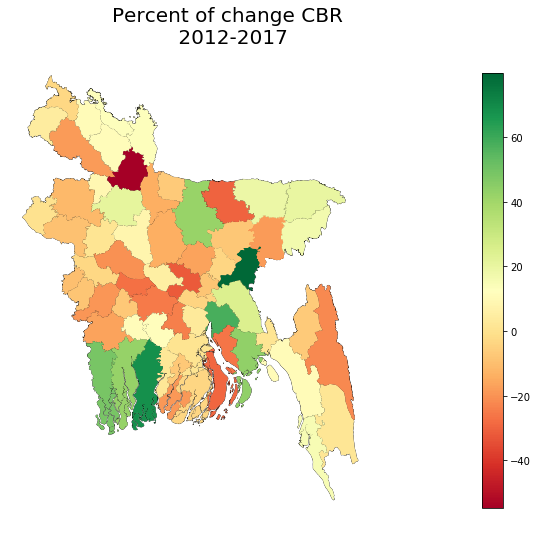

In [103]:
plt.rcParams["figure.figsize"] = [10,10]
plt.rcParams['axes.titlesize'] = 20

fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(llcrnrlon=87.8, llcrnrlat=20.3, urcrnrlon=94, urcrnrlat=27, resolution='f')
m.readshapefile(shapefile=SHAPEFILE, name=GEO_LEVEL, drawbounds=True)
df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.districts],
        'ZILA': [area['CC_2'] for area in m.districts_info]
    })
df_poly = df_poly.merge(plotting_data, on='ZILA', how='left')
cmap = plt.get_cmap('RdYlGn')   
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()
pc.set_facecolor(cmap(norm(df_poly['Percent of change CBR'].fillna(0).values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(df_poly['Percent of change CBR'])
plt.colorbar(mapper, shrink=0.8)
plt.title('Percent of change CBR \n 2012-2017')
ax.axis('off')
plt.savefig(os.path.join(OUTPUT, "CBR.jpeg"))
plt.show()
plt.close()

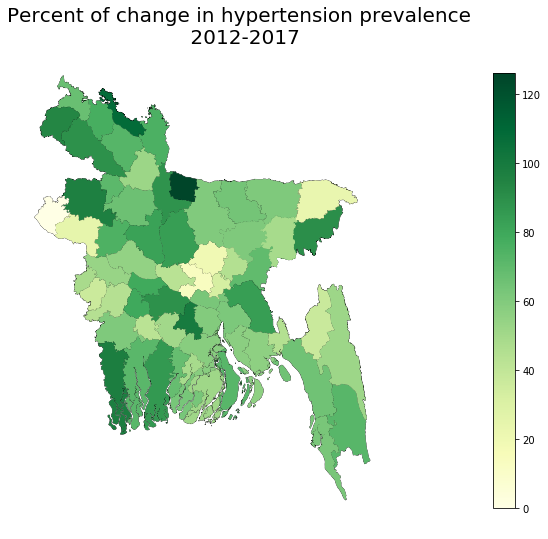

In [107]:
plt.rcParams["figure.figsize"] = [10,10]
plt.rcParams['axes.titlesize'] = 20

fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(llcrnrlon=87.8, llcrnrlat=20.3, urcrnrlon=94, urcrnrlat=27, resolution='f')
m.readshapefile(shapefile=SHAPEFILE, name=GEO_LEVEL, drawbounds=True)
df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.districts],
        'ZILA': [area['CC_2'] for area in m.districts_info]
    })
df_poly = df_poly.merge(plotting_data, on='ZILA', how='left')
cmap = plt.get_cmap('YlGn')   
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()
pc.set_facecolor(cmap(norm(df_poly['Percent of change Hypertension'].fillna(0).values)))
ax.add_collection(pc)

mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(df_poly['Percent of change Hypertension'])
plt.colorbar(mapper, shrink=0.8)
plt.title('Percent of change in hypertension prevalence \n 2012-2017')
ax.axis('off')
plt.savefig(os.path.join(OUTPUT, "hypertension.jpeg"))
plt.show()
plt.close()

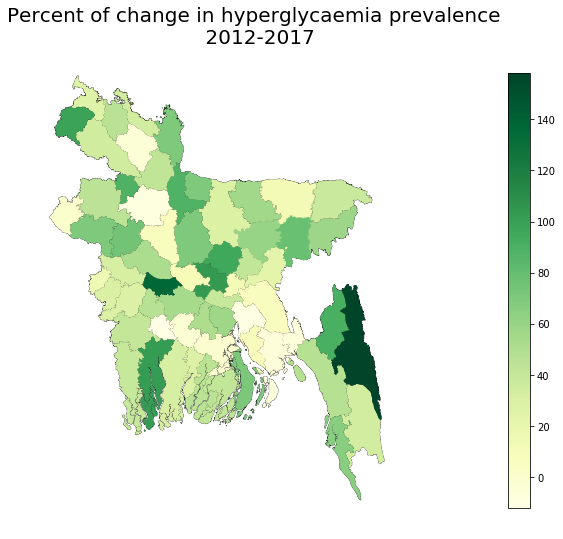

In [108]:
plt.rcParams["figure.figsize"] = [10,10]
plt.rcParams['axes.titlesize'] = 20

fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(llcrnrlon=87.8, llcrnrlat=20.3, urcrnrlon=94, urcrnrlat=27, resolution='f')
m.readshapefile(shapefile=SHAPEFILE, name=GEO_LEVEL, drawbounds=True)
df_poly = pd.DataFrame({
        'shapes': [Polygon(np.array(shape), True) for shape in m.districts],
        'ZILA': [area['CC_2'] for area in m.districts_info]
    })
df_poly = df_poly.merge(plotting_data, on='ZILA', how='left')
cmap = plt.get_cmap('YlGn')   
pc = PatchCollection(df_poly.shapes, zorder=2)
norm = Normalize()
pc.set_facecolor(cmap(norm(df_poly['Percent of change Hyperglycaemia'].fillna(0).values)))

ax.add_collection(pc)
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

mapper.set_array(df_poly['Percent of change Hyperglycaemia'])
plt.colorbar(mapper, shrink=0.8)
plt.title('Percent of change in hyperglycaemia prevalence \n 2012-2017')
ax.axis('off')

plt.savefig(os.path.join(OUTPUT, "hyperglycaemia.jpeg"))
plt.show()
plt.close()